# Course 2: Project - Task F - Finding correlations

<a name="task-f-top"></a>
This notebook is concerned with task F.

**Goal:** Identify the variables which most affect the nutritional score and provide some insight into which factors cause both a low or a high nutritional score.

**Contents:**
* [Imports](#task-f-imports)
* [Utilities](#task-f-utilities)
* [Data loading](#task-f-data-loading)
* [Finding correlations](#task-f-finding-correlations)

## Imports<a name="task-f-imports"></a> ([top](#task-f-top))
---

In [2]:
# Standard library:
import collections
import enum
import functools
import pathlib
import re
import typing as t
import urllib.parse

# 3rd party:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas.io.formats.style
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

# Project:
import cleanquantity
import ean
import tags
import utils

%matplotlib inline
register_matplotlib_converters()

## Utilities<a name="task-f-utilities"></a> ([top](#task-f-top))
---

We define a few utilities that we will use later in this notebook:

## Data loading<a name="task-f-data-loading"></a> ([top](#task-f-top))
---

First, we load the subset of the cleaned-up dataset that we need:

In [3]:
base_name = pathlib.Path.cwd().joinpath('en.openfoodfacts.org.products.clean')

As indicated, we restrict the data to 1000 rows and 5 columns of our choice:

In [4]:
# The columns to load:
usecols=[
    'code',
    'url',
    'creator',
    'created_on_utc',
    'product_name'
]

# Load the data-types:
data_types, parse_dates = utils.load_and_amend_dtypes(base_name)
# We can only parse dates in the columns that we are loading:
#parse_dates = list(set(parse_dates) & set(usecols))

# Load the data-frame:
df = pd.read_csv(
    f'{base_name}.csv',
    header=0,
    parse_dates=parse_dates,
#    usecols=usecols,
    dtype=data_types)

We get some general information:

In [5]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355569 entries, 0 to 355568
Data columns (total 154 columns):
code                                          355569 non-null object
url                                           355569 non-null object
creator                                       355566 non-null object
product_name                                  338067 non-null object
packaging                                     89856 non-null object
packaging_tags                                89883 non-null object
brands                                        326567 non-null object
brands_tags                                   326555 non-null object
categories                                    103178 non-null object
categories_tags                               103180 non-null object
categories_en                                 103180 non-null object
origins                                       24905 non-null object
origins_tags                                  24954 non-null ob

We look at the first few rows:

In [6]:
df.head()

,code,url,creator,product_name,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,...,nutrition-score-fr_100g,nutrition-score-uk_100g,created_on_utc,last_modified_on_utc,quantity_number,quantity_unit,first_packaging_code_lat,first_packaging_code_lon,serving_number,serving_unit
0,0000000003087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,Farine de blé noir,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,...,NaN,NaN,2016-09-17 09:17:46,2016-09-17 09:18:13,1000.0,g,NaN,NaN,NaN,NaN
1,0000000004530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,14.0,2017-03-09 14:32:37,2017-03-09 14:32:37,NaN,NaN,NaN,NaN,28.0,g
2,0000000004559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,Peanuts,NaN,NaN,Torn & Glasser,torn-glasser,NaN,NaN,...,0.0,0.0,2017-03-09 14:32:37,2017-03-09 14:32:37,NaN,NaN,NaN,NaN,28.0,g
3,0000000016087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,Organic Salted Nut Mix,NaN,NaN,Grizzlies,grizzlies,NaN,NaN,...,12.0,12.0,2017-03-09 10:35:31,2017-03-09 10:35:31,NaN,NaN,NaN,NaN,28.0,g
4,0000000016094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,Organic Polenta,NaN,NaN,Bob's Red Mill,bob-s-red-mill,NaN,NaN,...,NaN,NaN,2017-03-09 10:34:13,2017-03-09 10:34:13,NaN,NaN,NaN,NaN,35.0,g


In [7]:
df.shape

(355569, 154)

## Finding correlations<a name="task-f-the-task"></a> ([top](#task-f-top))
---

The first thing we set to do is to select a subset of the columns. We set the following guidelines: a) Exclude columns which are unrelated to nutrition. b) Ignore columns that correspond to the break-down of a macro-nutrient into micro-nutrients.

Taxonomy...

Nutrients:
* Macronutrients
  * Fats
    * Saturated
    * Trans
    * Unsaturated
      * Monounsaturated
      * Polyunsaturated
        * Omega-3
        * Omega-6
        * Omega-9
    * Cholesterol (?)
  * Carbohydrates
    * Sugars (simple)
    * Starches (complex)
    * Fibers (complex)
    * Polyols (reduced-calorie carbohydrates)
  * Proteins
    * Milk proteins
      * Casein
      * Serum proteins

* Micronutrients:
  * Vitamins
  * Minerals
  
* Other:
  * Cholesterol (lipoproteins, low-density lipoproteins (LDL) and high-density lipoproteins (HDL))
  * Nucleotides
  * Caffeine
  * Taurine

Salt is a chemical compound made up of sodium and chloride.

In [12]:
columns = [
 'additives_n',
 'ingredients_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil_n',
 'energy_100g',
 'energy-from-fat_100g',
 'fat_100g',
 'saturated-fat_100g',
 'monounsaturated-fat_100g',
 'polyunsaturated-fat_100g',
 'omega-3-fat_100g',
 'omega-6-fat_100g',
 'omega-9-fat_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'starch_100g',
 'polyols_100g',
 'fiber_100g',
 'proteins_100g',
 'casein_100g',
 'serum-proteins_100g',
 'nucleotides_100g',
 'salt_100g',
 'sodium_100g',
 'alcohol_100g',
 'vitamin-a_100g',
 'beta-carotene_100g',
 'vitamin-d_100g',
 'vitamin-e_100g',
 'vitamin-k_100g',
 'vitamin-c_100g',
 'vitamin-b1_100g',
 'vitamin-b2_100g',
 'vitamin-pp_100g',
 'vitamin-b6_100g',
 'vitamin-b9_100g',
 'folates_100g',
 'vitamin-b12_100g',
 'biotin_100g',
 'pantothenic-acid_100g',
 'silica_100g',
 'bicarbonate_100g',
 'potassium_100g',
 'chloride_100g',
 'calcium_100g',
 'phosphorus_100g',
 'iron_100g',
 'magnesium_100g',
 'zinc_100g',
 'copper_100g',
 'manganese_100g',
 'fluoride_100g',
 'selenium_100g',
 'chromium_100g',
 'molybdenum_100g',
 'iodine_100g',
 'caffeine_100g',
 'taurine_100g',
 'fruits-vegetables-nuts_100g',
 'fruits-vegetables-nuts-estimate_100g',
 'collagen-meat-protein-ratio_100g',
 'cocoa_100g',
 'nutrition-score-fr_100g',
 'nutrition-score-uk_100g',
]

In [23]:
columns_unsure = [
    'additives_n',
    'ingredients_from_palm_oil_n',
    'ingredients_that_may_be_from_palm_oil_n',
    'energy_100g',
    'energy-from-fat_100g',
    'collagen-meat-protein-ratio_100g',
    'cocoa_100g',
    'nutrition-score-fr_100g',
    'nutrition-score-uk_100g'
]

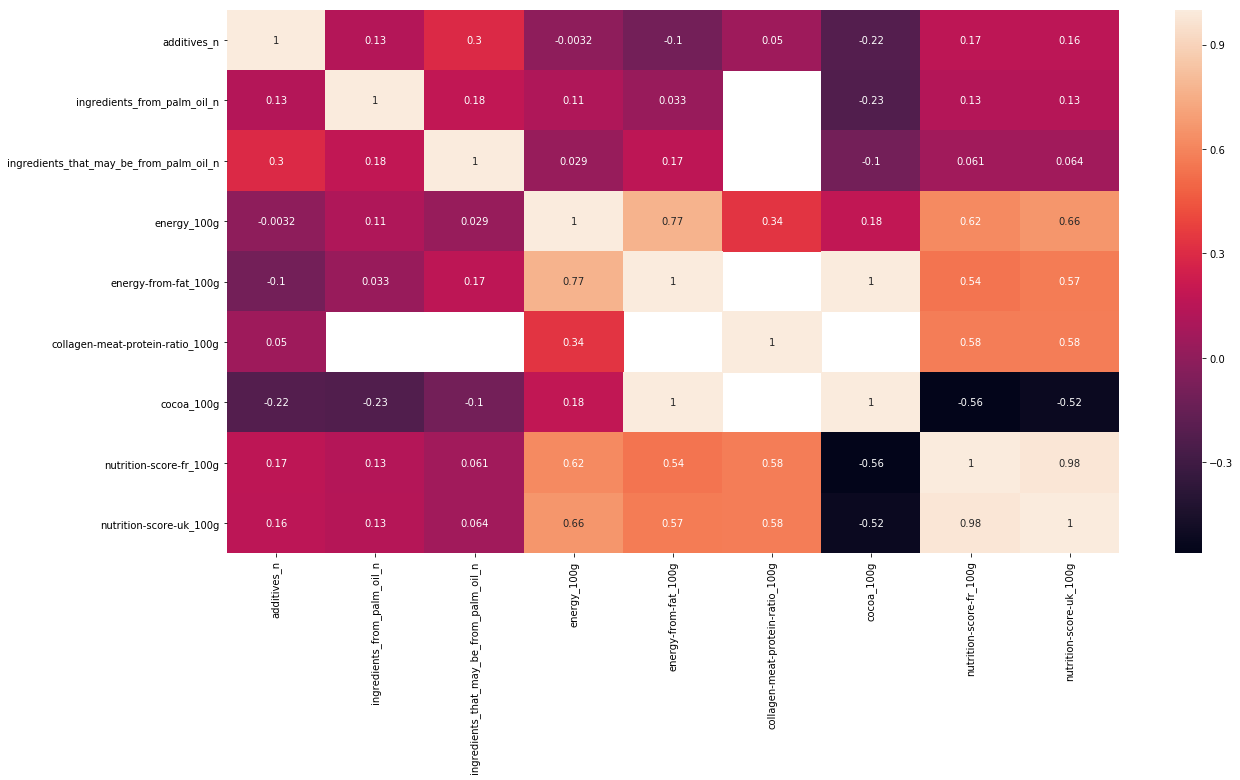

In [24]:
plt.figure(figsize=(20,10))
sns.heatmap(df[columns_unsure].corr(), annot = True)
plt.show()

In [31]:
columns_energy = [
    'energy_100g',
    'energy-from-fat_100g',
    'nutrition-score-fr_100g',
    'nutrition-score-uk_100g'
]

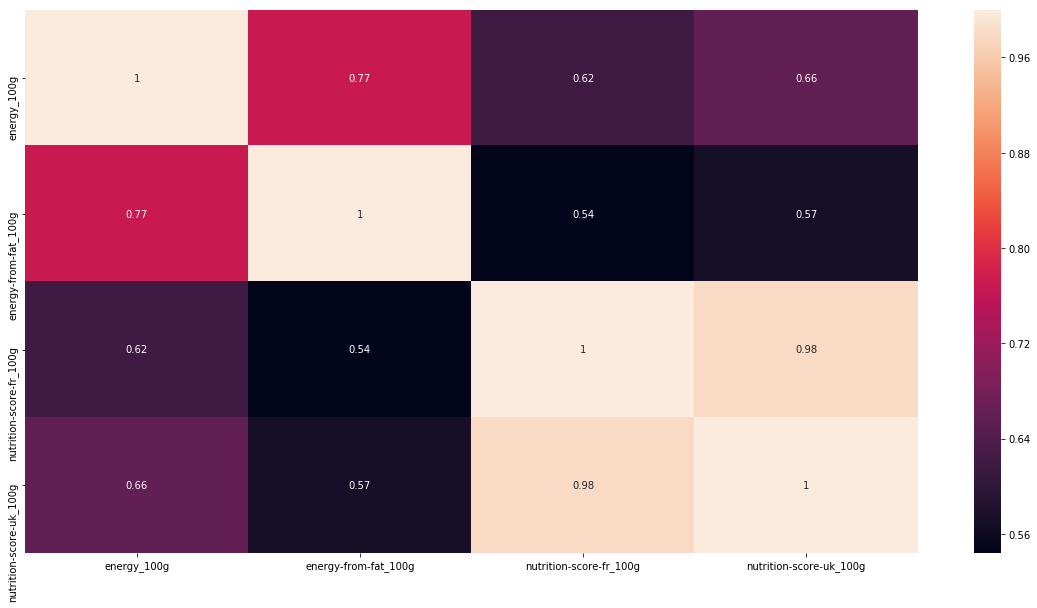

In [32]:
plt.figure(figsize=(20,10))
sns.heatmap(df[columns_energy].corr(), annot = True)
plt.show()

In [35]:
columns_fats = [
    'fat_100g',
    'saturated-fat_100g',
    'monounsaturated-fat_100g',
    'polyunsaturated-fat_100g',
    'omega-3-fat_100g',
    'omega-6-fat_100g',
    'omega-9-fat_100g',
    'trans-fat_100g',
    'cholesterol_100g',
    'nutrition-score-fr_100g',
    'nutrition-score-uk_100g'
]

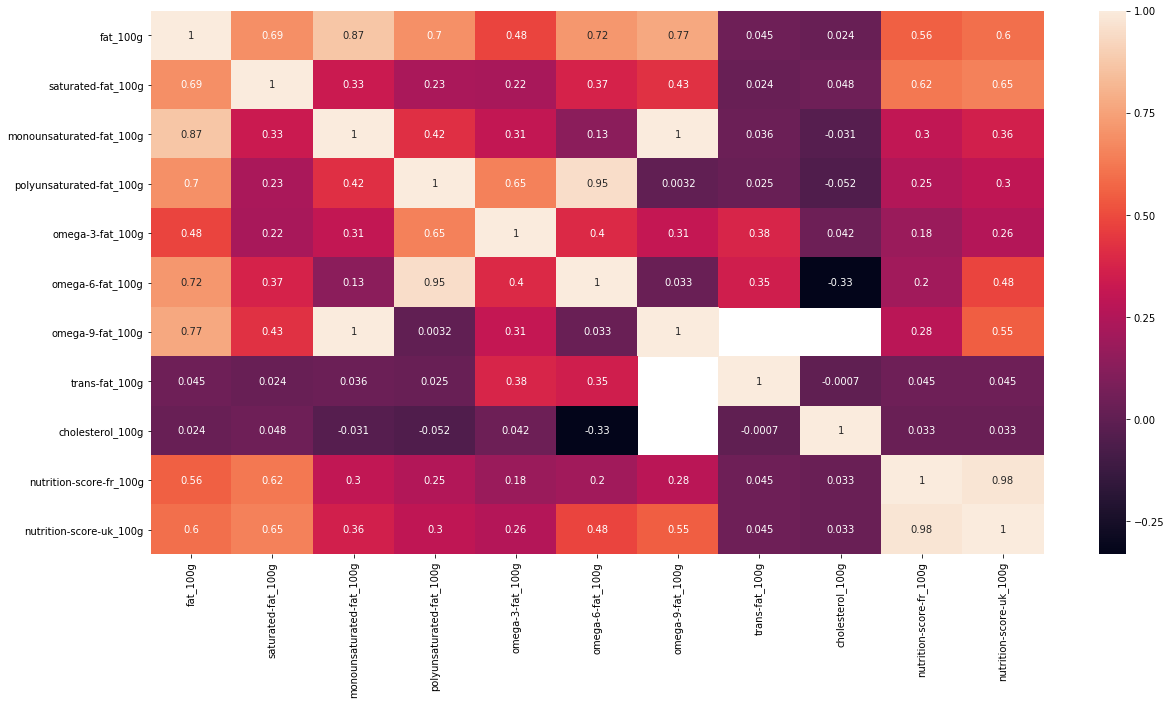

In [36]:
plt.figure(figsize=(20,10))
sns.heatmap(df[columns_fats].corr(), annot = True)
plt.show()

In [39]:
columns_sugars = [
    'carbohydrates_100g',
    'sugars_100g',
    'starch_100g',
    'polyols_100g',
    'fiber_100g',
    'nutrition-score-fr_100g',
    'nutrition-score-uk_100g'
]

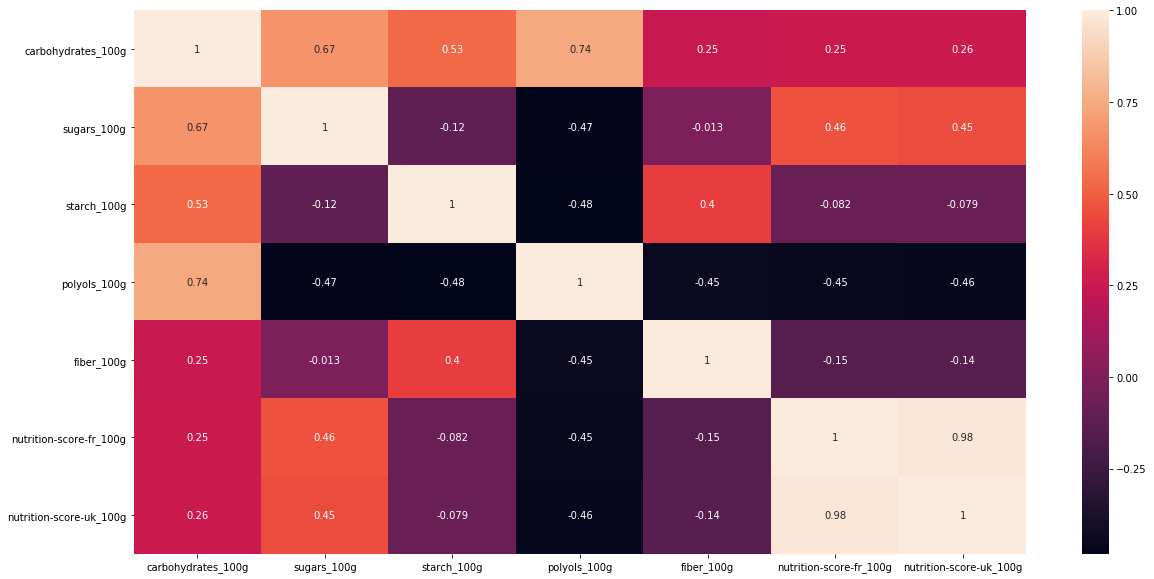

In [40]:
plt.figure(figsize=(20,10))
sns.heatmap(df[columns_sugars].corr(), annot = True)
plt.show()

In [43]:
columns_protein = [
    'proteins_100g',
    'casein_100g',
    'serum-proteins_100g',
    'nucleotides_100g',
    'nutrition-score-fr_100g',
    'nutrition-score-uk_100g'
]

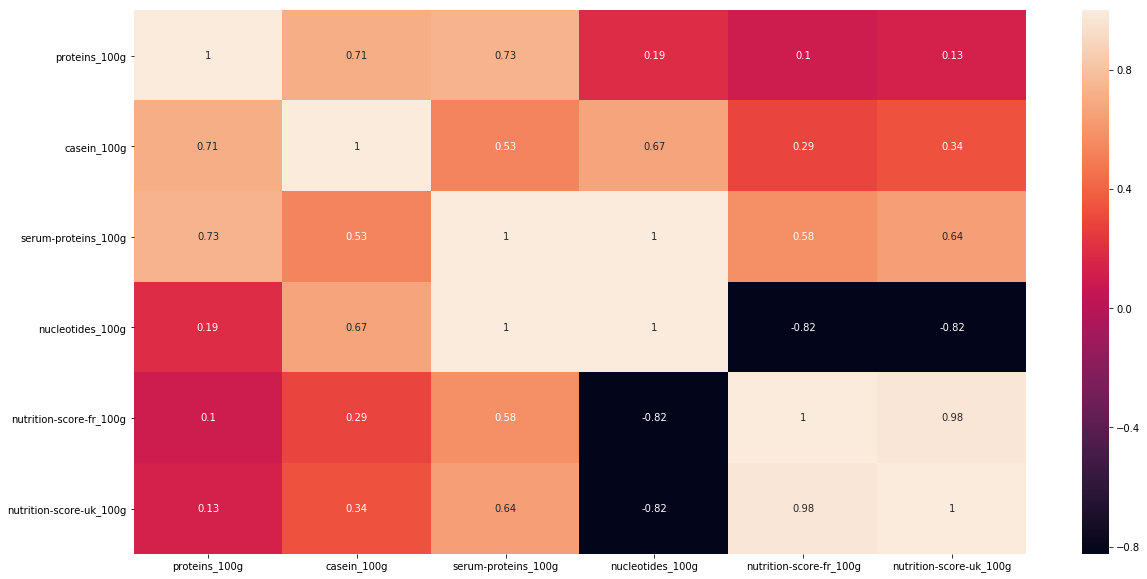

In [44]:
plt.figure(figsize=(20,10))
sns.heatmap(df[columns_protein].corr(), annot = True)
plt.show()

In [47]:
columns_salt_and_alcool = [
    'salt_100g',
    'sodium_100g',
    'alcohol_100g',
    'nutrition-score-fr_100g',
    'nutrition-score-uk_100g'
]

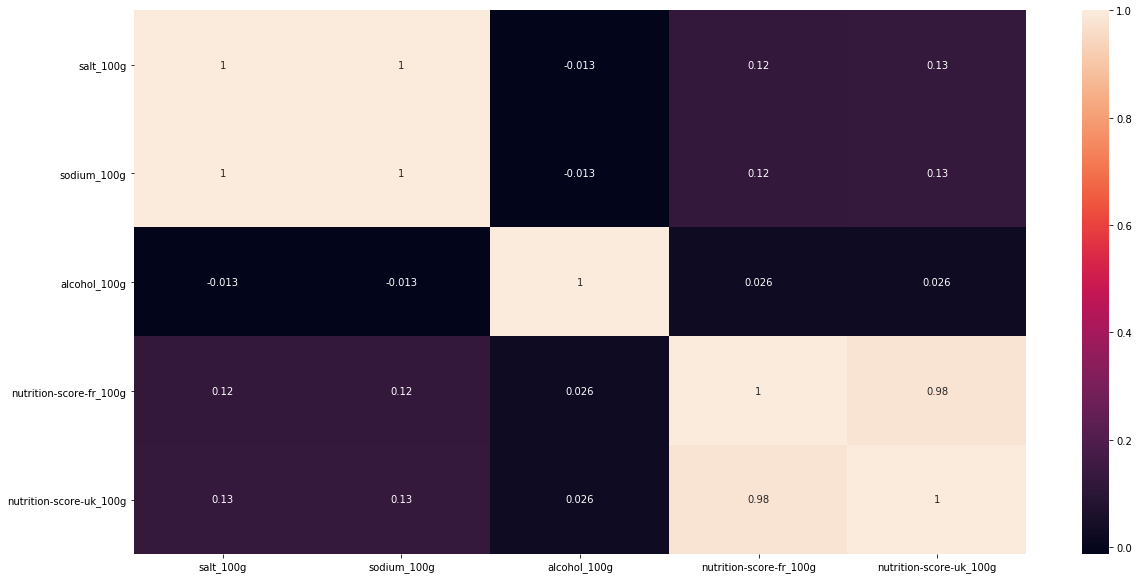

In [48]:
plt.figure(figsize=(20,10))
sns.heatmap(df[columns_salt_and_alcool].corr(), annot = True)
plt.show()

In [51]:
columns_vitamins = [
    'vitamin-a_100g',
    'beta-carotene_100g',
    'vitamin-d_100g',
    'vitamin-e_100g',
    'vitamin-k_100g',
    'vitamin-c_100g',
    'vitamin-b1_100g',
    'vitamin-b2_100g',
    'vitamin-pp_100g',
    'vitamin-b6_100g',
    'vitamin-b9_100g',
    'folates_100g',
    'vitamin-b12_100g',
    'biotin_100g',
    'pantothenic-acid_100g',
    'nutrition-score-fr_100g',
    'nutrition-score-uk_100g'
]

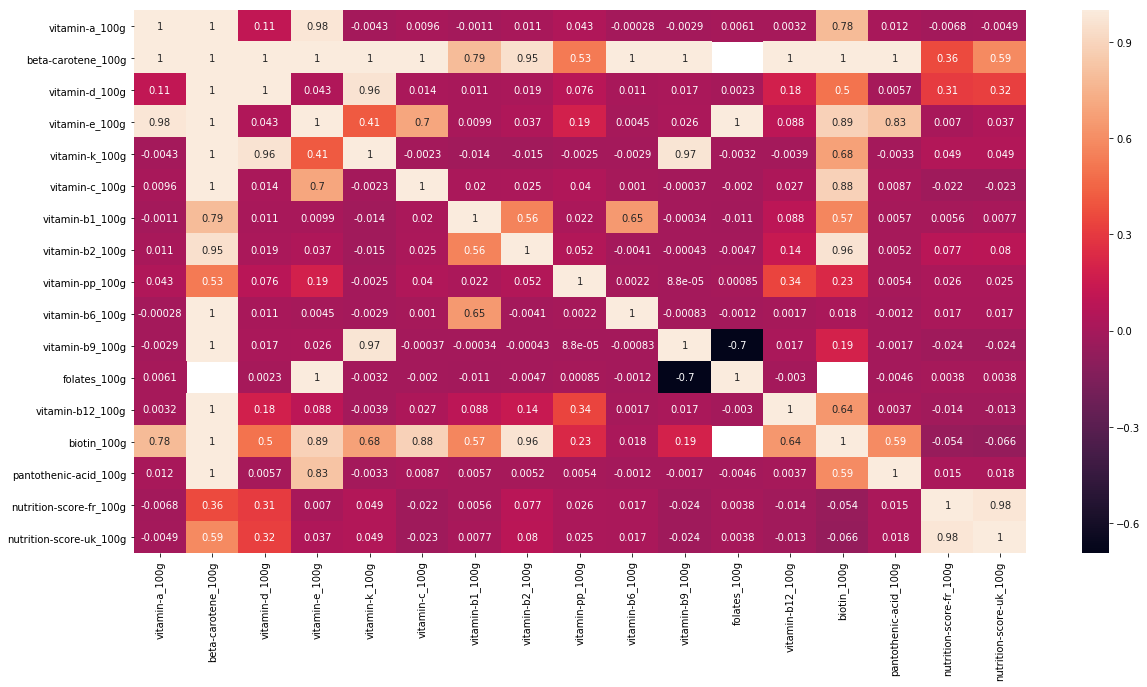

In [52]:
plt.figure(figsize=(20,10))
sns.heatmap(df[columns_vitamins].corr(), annot = True)
plt.show()

In [56]:
columns_minerals = [
    'silica_100g',
    'bicarbonate_100g',
    'potassium_100g',
    'chloride_100g',
    'calcium_100g',
    'phosphorus_100g',
    'iron_100g',
    'magnesium_100g',
    'zinc_100g',
    'copper_100g',
    'manganese_100g',
    'fluoride_100g',
    'selenium_100g',
    'chromium_100g',
    'molybdenum_100g',
    'iodine_100g',
    'caffeine_100g',
    'taurine_100g',
    'nutrition-score-fr_100g',
    'nutrition-score-uk_100g'
]

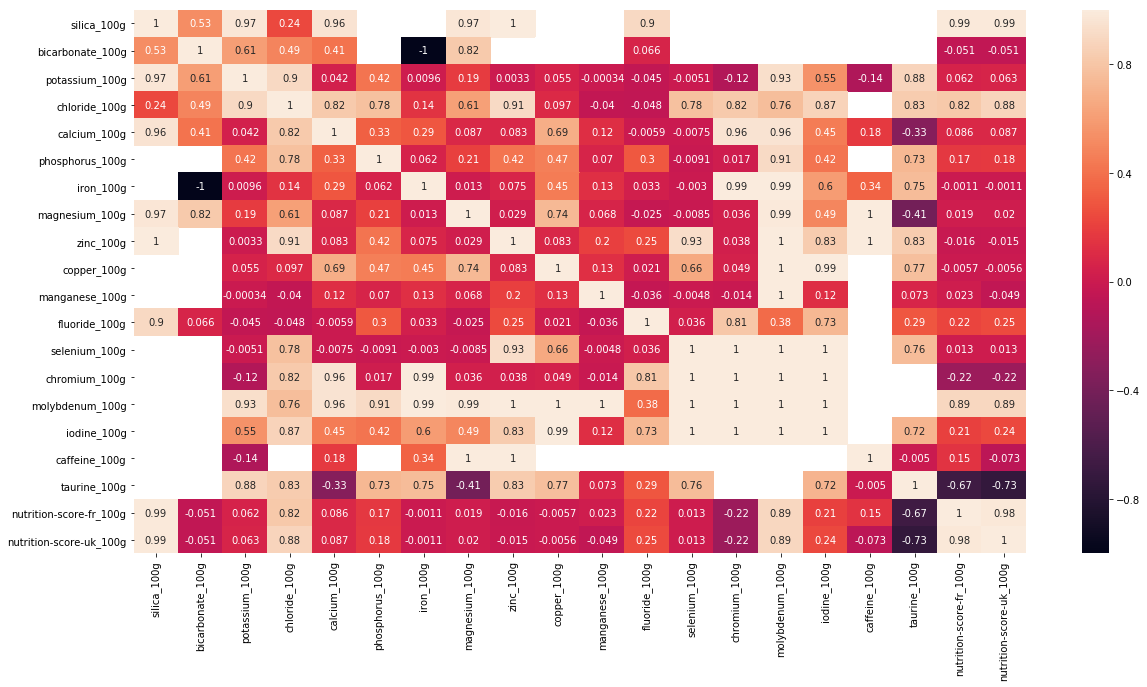

In [57]:
plt.figure(figsize=(20,10))
sns.heatmap(df[columns_minerals].corr(), annot = True)
plt.show()

In [58]:
columns_others = [
    'fruits-vegetables-nuts_100g',
    'fruits-vegetables-nuts-estimate_100g',
    'collagen-meat-protein-ratio_100g',
    'nutrition-score-fr_100g',
    'nutrition-score-uk_100g'
]

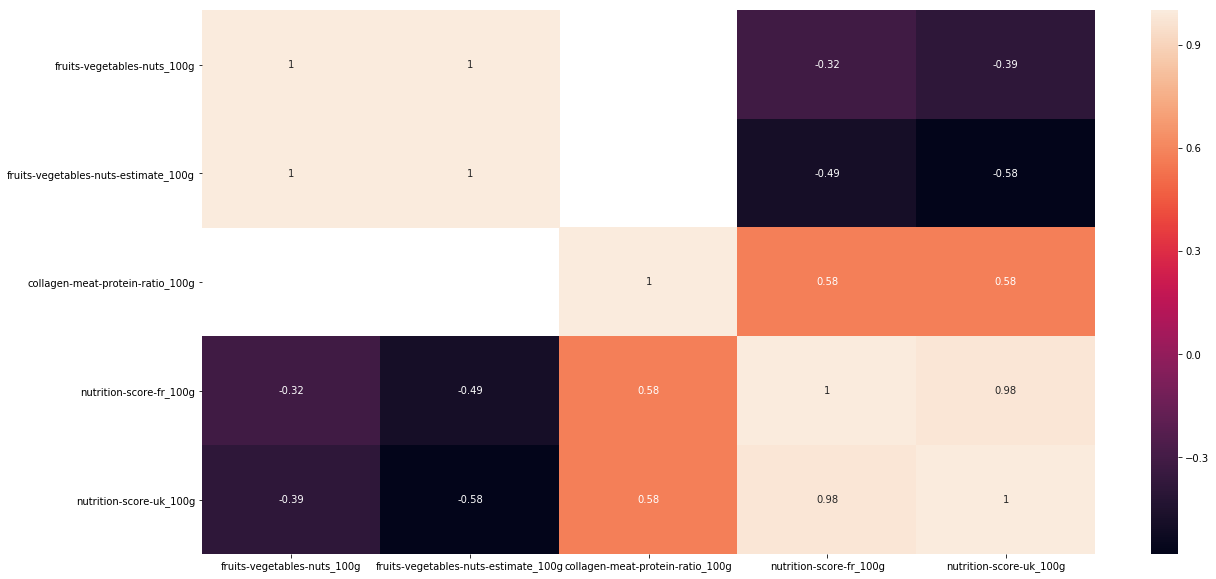

In [59]:
plt.figure(figsize=(20,10))
sns.heatmap(df[columns_others].corr(), annot = True)
plt.show()

In [65]:
columns = [
    'pnns_groups_1',
    'pnns_groups_2',
    'nutrition-score-fr_100g',
    'nutrition-score-uk_100g'
]

In [68]:
df['pnns_groups_1']

0                           NaN
1                           NaN
2                           NaN
3                           NaN
4                           NaN
5                           NaN
6                           NaN
7                           NaN
8                           NaN
9                           NaN
10                          NaN
11                          NaN
12                          NaN
13                          NaN
14                          NaN
15                          NaN
16                          NaN
17                          NaN
18                          NaN
19                          NaN
20                          NaN
21                          NaN
22                          NaN
23                          NaN
24                          NaN
25                          NaN
26                          NaN
27                          NaN
28                          NaN
29                          NaN
                  ...          
355539  

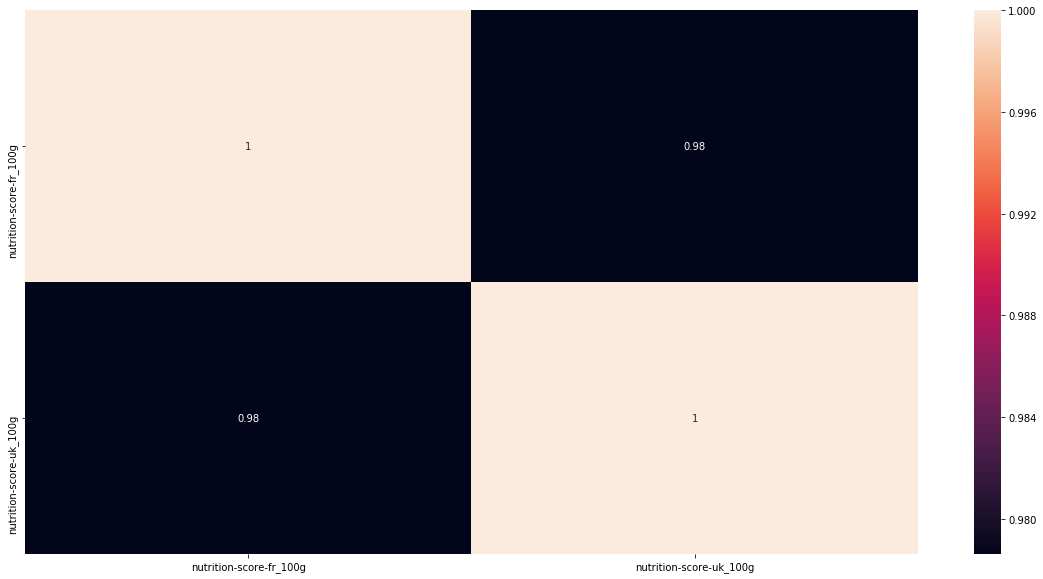

In [66]:
plt.figure(figsize=(20,10))
sns.heatmap(df[columns].corr(), annot = True)
plt.show()